# Filters

This section includes information about filters, which can be a very painful process and somewhat obtuse.  

Filters are basically anything that manipulates the time series data into something else.  This includes scaling, removing instrument response, removing trends, notch filtering, passband filtering, etc.  We want to work with data that is in physical units, but the data are often collected in digital counts.  To transform between the two we need to apply or unapply certain filters.  When going from physical units to digital counts we are applying filters, `channel_metadata.filter.applied = [True]`, whereas going from counts to physical units we are unapplying the filters `channel_metadata.filter.applied = [False]`.  This may seem backwards, but this is the way most archived data is thought of. Then any filter applied to physical units for the purposes of cleaning the data are `channel_metadata.filter.applied = [True]`.     

**Note**: currently there are not tools to convert digital counts to physical units, this is a work in progress.  Nevertheless all the information is there for you to do the transformation.  

Supported filters in `mt_metadata.timeseries.filters` are: 

| **Filter** | **Description** |
|--------|-------------|
| **CoefficientFilter** | A coefficient filter scales the data by a given factor, a real value. |
| **FIRFilter** | A finite impulse response filter is commonly an anti-alias filter and is represented as a 1-D array of real valued coefficients.| 
| **PoleZeroFilter** | A pole-zero filter is often an type of bandpass filter.  It is represented as symmetric complex poles and zeros with a scale factor |
| **TimeDelayFilter** | A time delay filter delays the data by a real valued time delay.  A negative value is a delay and a positive value is a prediction.  | 
| **FrequencyResponseTableFilter** | A frequency, amplitude, phase look-up table, commonly in physical units and degrees.  This is commonly how manufacturers provide instrument responses.|
| **ChannelResponseFilter** | A comprehensive representation of all filters.  Contains a list of all filters, should be the most commonly used filter object as it can compute the total response, and estimate the passband and normalization frequency.  |


## Filter Base

All filters inherit from a `FilterBase` class, which has attributes and methods common to all filters.  

### Units

The two common to all filters are `units_in` and `units_out`.  These attributes are key as they describes how the filters are transforming the data.  The units should be SI units and given as all lowercase full names.  For example Volts would be `volts` and V/m would be `volts per meter`.  All units are represented in short form.    

### Complex Response

A method is provided to compute the complex response, this is slightly different for each filter and the method overwritten by the different filters.   

In [1]:
%matplotlib inline
import numpy as np

# make a general frequency array to calculate complex response
# note that these are linear frequencies and the complex response uses angular frequencies
frequencies = np.logspace(-3, 3, 50)

## Coefficient Filter
A coefficient filter is relatively simple.  It includes a scale factor represented as `gain`.

In [2]:
from mt_metadata.timeseries.filters import CoefficientFilter

In [3]:
cf = CoefficientFilter(units_in="volts", units_out="V/m", gain=100.0, name="example_coefficient_filter")
cf

{
    "coefficient_filter": {
        "calibration_date": "1980-01-01",
        "gain": 100.0,
        "name": "example_coefficient_filter",
        "type": "coefficient",
        "units_in": "V",
        "units_out": "V/m"
    }
}

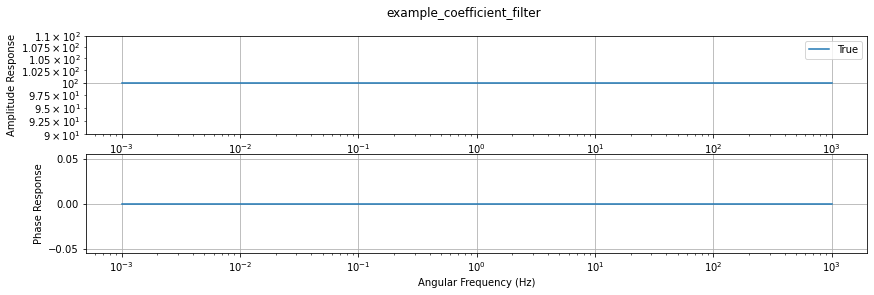

In [4]:
cf.plot_response(frequencies, x_units="frequency")

## FIR Filter
An finite impulse response filter is commonly used as an anti-alias filter, and is represented as a 1-D array of real valued coefficients.  

In [5]:
from mt_metadata.timeseries.filters import FIRFilter

In [6]:
fir = FIRFilter(
    units_in="volts",
    units_out="volts",
    name="example_fir",
    decimation_input_sample_rate=32000,
    gain=0.999904,
    symmetry="EVEN",
    decimation_factor=16,
)

fir.coefficients = [
    1.0828314e-06, 1.7808272e-06, 3.2410387e-06, 5.4627321e-06, 8.682945e-06, 1.3240843e-05, 1.9565294e-05,
    2.8185128e-05, 3.9656901e-05, 5.4688699e-05, 7.4153548e-05, 9.8989171e-05, 0.00013036761, 0.00016954952,
    0.00021798223, 0.00027731725, 0.00034936491, 0.00043613836, 0.00053984317, 0.0006628664, 0.00080777059,
    0.00097733398, 0.0011744311, 0.0014021378, 0.0016635987, 0.0019620692, 0.0023008469, 0.0026832493,
    0.0031125348, 0.0035918986, 0.0041243695, 0.0047127693, 0.0053596641, 0.0060672448, 0.0068373145,
    0.0076711699, 0.0085695535, 0.0095325625, 0.010559602, 0.01164928, 0.012799387, 0.014006814, 0.015267504,
    0.016576445, 0.017927598, 0.019313928, 0.020727372, 0.022158878, 0.023598416, 0.025035053, 0.026456987,
    0.027851671, 0.029205887, 0.030505868, 0.031737458, 0.032886244, 0.03393773, 0.034877509, 0.035691477,
    0.036365997, 0.036888145, 0.037245877, 0.03742826, 0.037425674, 0.03723, 0.036834806, 0.036235519,
    0.035429578, 0.034416564, 0.033198304, 0.031778947, 0.030165028, 0.028365461, 0.026391543, 0.024256891,
    0.021977346, 0.019570865, 0.017057346, 0.014458441, 0.011797323, 0.009098433, 0.0063871844, 0.0036896705,
    0.0010323179, -0.0015584482, -0.0040565561, -0.0064366534, -0.0086744577, -0.010747112, -0.012633516,
    -0.014314661, -0.0157739, -0.01699724, -0.017973563, -0.018694809, -0.019156145, -0.01935605, -0.019296378,
    -0.018982368, -0.018422581, -0.017628808, -0.016615927, -0.015401681, -0.014006456, -0.012452973,
    -0.010765962, -0.0089718029, -0.0070981304, -0.0051734182, -0.0032265538, -0.0012863991, 0.0006186511,
    0.0024610918, 0.0042147399, 0.0058551184, 0.0073598339, 0.0087089101, 0.0098850802, 0.01087404, 0.011664648,
    0.012249067, 0.012622863, 0.012785035, 0.012737988, 0.012487462, 0.01204238, 0.011414674, 0.010619033,
    0.0096726287, 0.0085947802, 0.007406604, 0.006130626, 0.0047903718, 0.0034099557, 0.002013647, 0.00062545808,
    -0.0007312728, -0.0020342721, -0.0032627005, -0.0043974896, -0.0054216445, -0.0063205026, -0.0070819431,
    -0.0076965573, -0.0081577515, -0.0084618134, -0.0086079109, -0.0085980454, -0.0084369555, -0.0081319623,
    -0.0076927822, -0.0071312929, -0.0064612622, -0.005698049, -0.0048582871, -0.0039595389, -0.0030199524,
    -0.0020579058, -0.0010916605, -0.00013902181, 0.00078298012, 0.0016583927, 0.0024726097, 0.0032126096,
    0.0038671608, 0.0044269804, 0.0048848582, 0.005235733, 0.0054767267, 0.0056071337, 0.0056283739,
    0.0055438946, 0.0053590466, 0.0050809216, 0.0047181565, 0.0042807218, 0.0037796798, 0.0032269375,
    0.0026349833, 0.0020166242, 0.001384723, 0.00075194426, 0.00013050952, -0.00046802824, -0.0010329896,
    -0.0015547526, -0.0020249044, -0.0024363673, -0.0027834927, -0.0030621202, -0.0032696081, -0.0034048304,
    -0.003468141, -0.0034613123, -0.003387446, -0.0032508562, -0.003056939, -0.0028120177, -0.0025231787,
    -0.0021980959, -0.0018448512, -0.001471751, -0.0010871479, -0.00069926586, -0.00031603608, 5.5052958e-05,
    0.00040709358, 0.00073387625, 0.0010299878, 0.0012908906, 0.0015129783, 0.0016936094, 0.0018311206,
    0.0019248178, 0.0019749457, 0.0019826426, 0.0019498726, 0.0018793481, 0.001774437, 0.0016390601,
    0.0014775817, 0.0012946966, 0.0010953132, 0.00088443852, 0.00066706788, 0.00044807568, 0.00023212004,
    2.3551687e-05, -0.00017366471, -0.00035601447, -0.00052048819, -0.00066461961, -0.0007865114, -0.00088484585,
    -0.00095888576, -0.0010084547, -0.0010339168, -0.0010361352, -0.0010164281, -0.00097651512, -0.0009184563,
    -0.00084458862, -0.00075745879, -0.00065975531, -0.0005542388, -0.00044368068, -0.00033079527, -0.00021818698,
    -0.0001082966, -3.3548122e-06, 9.4652831e-05, 0.00018401834, 0.00026333242, 0.00033149892, 0.00038773834,
    0.00043159194, 0.00046290434, 0.0004818163, 0.0004887383, 0.00048432534, 0.00046944799, 0.00044515711,
    0.0004126484, 0.0003732258, 0.00032826542, 0.0002791743, 0.00022736372, 0.0001742071, 0.00012101705,
    6.9016627e-05, 1.9314915e-05, -2.7108661e-05, -6.9420195e-05, -0.00010694123, -0.00013915499, -0.00016570302,
    -0.00018639189, -0.00020117435, -0.00021015058, -0.00021354953, -0.00021171506, -0.00020509114, -0.00019420317,
    -0.00017963824, -0.00016202785, -0.00014203126, -0.00012030972, -9.7522447e-05, -7.4297881e-05, -5.1229126e-05,
    -2.8859566e-05, -7.6714587e-06, 1.191924e-05, 2.9567975e-05, 4.5006156e-05, 5.8043028e-05, 6.8557049e-05,
    7.6507284e-05, 8.1911501e-05, 8.4854546e-05, 8.5473977e-05, 8.3953237e-05, 8.0514517e-05, 7.5410928e-05,
    6.8914269e-05, 6.1308667e-05, 5.2886291e-05, 4.3926615e-05, 3.4708195e-05, 2.5484322e-05, 1.6489239e-05,
    7.9309229e-06, -1.335887e-08, -7.1985955e-06, -1.3510014e-05, -1.8867066e-05, -2.32245e-05, -2.6558888e-05,
    -2.8887769e-05, -3.0242758e-05, -3.0684769e-05, -3.0291432e-05, -2.9154804e-05, -2.7376906e-05, -2.5070442e-05,
    -2.2347936e-05, -1.9321938e-05, -1.6109379e-05, -1.2808429e-05, -9.5234091e-06, -6.3382245e-06,
    -3.3291028e-06, -5.5987789e-07, 1.9187619e-06, 4.072373e-06, 5.8743913e-06, 7.312286e-06, 8.3905516e-06,
    9.10975e-06, 9.4979405e-06, 9.5751602e-06, 9.3762619e-06, 8.9382884e-06, 8.301693e-06, 7.5045982e-06,
    6.592431e-06, 5.6033018e-06, 4.5713236e-06, 3.5404175e-06, 2.5302468e-06, 1.5771827e-06, 6.9930724e-07,
    -8.6047464e-08, -7.6676685e-07, -1.3332562e-06, -1.7875625e-06, -2.1266892e-06, -2.35267e-06, -2.4824365e-06,
    -2.5098916e-06, -2.4598471e-06, -2.335345e-06, -2.1523615e-06, -1.9251499e-06, -1.6707684e-06, -1.3952398e-06,
    -1.1173763e-06, -8.4543007e-07, -5.7948262e-07, -3.444687e-07, -1.2505329e-07, 6.1743521e-08, 2.1873758e-07,
    3.4424812e-07, 4.3748074e-07, 4.931357e-07, 5.2551894e-07, 5.344753e-07, 5.136161e-07, 4.9029785e-07,
    4.3492003e-07, 3.8198567e-07, 3.2236682e-07, 2.6023093e-07, 1.9363162e-07, 1.3382508e-07, 6.8672463e-08,
    2.1443693e-08, -1.9671351e-09, -4.7522178e-08, -6.2719053e-08, -1.0190665e-07, -1.2015286e-07, -1.103657e-07,
    -1.0294882e-07, -1.1965994e-07, -1.3612285e-07, -1.463918e-07, -1.4752351e-07, 3.9802276e-07]

2021-11-19 12:24:13,321 [line 261] mt_metadata.base.metadata.f_i_r_filter.pass_band - WARNING: Passband appears discontinuous


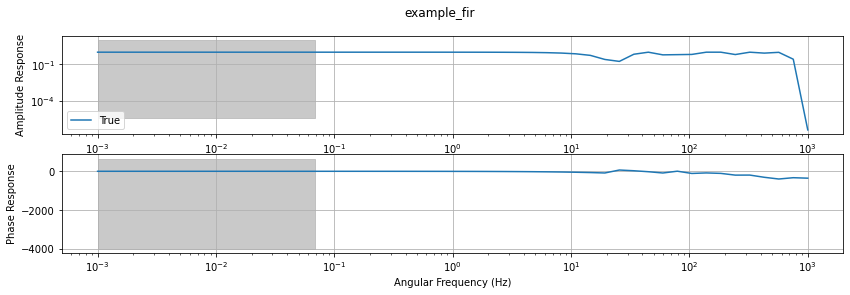

In [7]:
fir.plot_response(frequencies, x_units="frequency")

In [9]:
print(f"Pass Band frequency range estimation: {fir.pass_band(frequencies)}") 

2021-11-19 12:25:08,464 [line 261] mt_metadata.base.metadata.f_i_r_filter.pass_band - WARNING: Passband appears discontinuous


Pass Band frequency range estimation: [ 0.001       0.06866488]


## Pole Zero Filter

A pole-zero filter is a mathematical way to represent a filter using complex valued poles and zeros and a scaling factor.  The advantage of the pole-zero representation is that arbitrary frequency ranges can be computed without having to extrapolate.  

In [ ]:
from mt_metadata.timeseries.filters import PoleZeroFilter

In [ ]:
pz = PoleZeroFilter(units_in="volts", units_out="nanotesla", name="example_zpk_response")
pz.poles = [(-6.283185+10.882477j), (-6.283185-10.882477j), (-12.566371+0j)]
pz.zeros = []
pz.normalization_factor = 2002.269
pz

In [ ]:
pz.plot_response(frequencies, x_units="frequency")

In [ ]:
print(f"Pass Band frequency range estimation: {pz.pass_band()}") 

## Time Delay Filter

A time delay filter are often incorporated in the AD converter that controls mulitple channels and creates a small time delay as it shifts between the channels. A positive value predicts time and a negative value delays time.  For causality the value should always be negative. The delay is givne in seconds.  

In [ ]:
from mt_metadata.timeseries.filters import TimeDelayFilter

In [ ]:
td = TimeDelayFilter(units_in="volts", units_out="volts", name="example_time_delay", delay=-.25)
td

In [ ]:
td.plot_response(frequencies, x_units="frequency")

## FrequencyResponseTableFilter

Commonly to calibrate the frequency response of an instrument a manufacturer will run a calibration taking measurements at discrete frequencies and then supplying a table of frequency, amplitude, and phase for the users.  This is more accurate than pole-zero representation but has limitations in that extrapolation needs to be applied to frequencies outside of the calibrated frequencies and interpolation between calibrated frequencies.  

**Note**: phase is assumed to be in degrees.  

In [ ]:
from mt_metadata.timeseries.filters import FrequencyResponseTableFilter

In [ ]:
fap = FrequencyResponseTableFilter(units_in="volts", units_out="nanotesla", name="example_fap")

fap.frequencies = [  
    1.95312000e-03,   2.76214000e-03,   3.90625000e-03,
     5.52427000e-03,   7.81250000e-03,   1.10485000e-02,
     1.56250000e-02,   2.20971000e-02,   3.12500000e-02,
     4.41942000e-02,   6.25000000e-02,   8.83883000e-02,
     1.25000000e-01,   1.76780000e-01,   2.50000000e-01,
     3.53550000e-01,   5.00000000e-01,   7.07110000e-01,
     1.00000000e+00,   1.41420000e+00,   2.00000000e+00,
     2.82840000e+00,   4.00000000e+00,   5.65690000e+00,
     8.00000000e+00,   1.13140000e+01,   1.60000000e+01,
     2.26270000e+01,   3.20000000e+01,   4.52550000e+01,
     6.40000000e+01,   9.05100000e+01,   1.28000000e+02,
     1.81020000e+02,   2.56000000e+02,   3.62040000e+02,
     5.12000000e+02,   7.24080000e+02,   1.02400000e+03,
     1.44820000e+03,   2.04800000e+03,   2.89630000e+03,
     4.09600000e+03,   5.79260000e+03,   8.19200000e+03,
     1.15850000e+04]

fap.amplitudes = [  
    1.59009000e-03,   3.07497000e-03,   5.52793000e-03,
    9.47448000e-03,   1.54565000e-02,   2.49498000e-02,
    3.96462000e-02,   7.87192000e-02,   1.57134000e-01,
    3.09639000e-01,   5.94224000e-01,   1.12698000e+00,
    2.01092000e+00,   3.33953000e+00,   5.00280000e+00,
    6.62396000e+00,   7.97545000e+00,   8.82872000e+00,
    9.36883000e+00,   9.64102000e+00,   9.79664000e+00,
    9.87183000e+00,   9.90666000e+00,   9.92845000e+00,
    9.93559000e+00,   9.93982000e+00,   9.94300000e+00,
    9.93546000e+00,   9.93002000e+00,   9.90873000e+00,
    9.86383000e+00,   9.78129000e+00,   9.61814000e+00,
    9.26461000e+00,   8.60175000e+00,   7.18337000e+00,
    4.46123000e+00,  -8.72600000e-01,  -5.15684000e+00,
    -2.95111000e+00,  -9.28512000e-01,  -2.49850000e-01,
    -5.75682000e-02,  -1.34293000e-02,  -1.02708000e-03,
    1.09577000e-03]

fap.phases = [  
    7.60824000e-02,   1.09174000e-01,   1.56106000e-01,
    2.22371000e-01,   3.12020000e-01,   4.41080000e-01,
    6.23548000e-01,   8.77188000e-01,   1.23360000e+00,
    1.71519000e+00,   2.35172000e+00,   3.13360000e+00,
    3.98940000e+00,   4.67269000e+00,   4.96593000e+00,
    4.65875000e+00,   3.95441000e+00,   3.11098000e+00,
    2.30960000e+00,   1.68210000e+00,   1.17928000e+00,
    8.20015000e-01,   5.36474000e-01,   3.26955000e-01,
    1.48051000e-01,  -8.24275000e-03,  -1.66064000e-01,
    -3.48852000e-01,  -5.66625000e-01,  -8.62435000e-01,
    -1.25347000e+00,  -1.81065000e+00,  -2.55245000e+00,
    -3.61512000e+00,  -5.00185000e+00,  -6.86158000e+00,
    -8.78698000e+00,  -9.08920000e+00,  -4.22925000e+00,
     2.15533000e-01,   6.00661000e-01,   3.12368000e-01,
     1.31660000e-01,   5.01553000e-02,   1.87239000e-02,
     6.68243000e-03]

In [ ]:
fap.plot_response(frequencies, x_units="frequency", unwrap=True)

In [ ]:
print(f"Pass Band frequency range estimation: {fap.pass_band(tol=1e-1)}") 